In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import keras
import keras_nlp

from datetime import datetime


In [33]:
keras.utils.set_random_seed(69)

In [34]:
df = pd.read_csv("../data/clean/2024-10-28_21-01-53.csv")
df.head()

,Task,Category
0,Finish Quarterly Report,urgent important
1,Schedule Meeting with Client X,urgent important
2,Respond to Urgent Email,urgent not-important
3,Clean Desk,not-urgent not-important
4,Learn New Programming Language,not-urgent important


# Create Dataset

In [35]:
sentences = df["Task"].to_numpy()
labels = df["Category"].to_numpy()

dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))
dataset = dataset.shuffle(len(dataset))

print(sentences[:10])
print()
print(labels[:10])

['Finish Quarterly Report' 'Schedule Meeting with Client X'
 'Respond to Urgent Email' 'Clean Desk' 'Learn New Programming Language'
 'Pay Monthly Bills' 'Exercise Regularly' 'Read Book on Leadership'
 'Attend Networking Event' 'Plan Vacation']

['urgent important' 'urgent important' 'urgent not-important'
 'not-urgent not-important' 'not-urgent important' 'urgent not-important'
 'not-urgent important' 'not-urgent important' 'not-urgent important'
 'not-urgent important']


# Hyperparameters

In [36]:
EMBEDDING_DIM = 100
MAX_LENGTH = 32
TRAINING_SPLIT = 0.9
NUM_BATCHES = 128

# Split Dataset

In [37]:
train_size = int(len(dataset) * TRAINING_SPLIT)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

train_ds = train_ds.batch(NUM_BATCHES)
val_ds = val_ds.batch(NUM_BATCHES)

print(f"There are {len(train_ds)} batches for a total of {NUM_BATCHES*len(train_ds)} elements for training.")
print(f"There are {len(val_ds)} batches for a total of {NUM_BATCHES*len(val_ds)} elements for validation.")

There are 9 batches for a total of 1152 elements for training.
There are 1 batches for a total of 128 elements for validation.


# Vectorize Dataset

In [38]:
train_sentences = train_ds.map(lambda x, _: x)  
train_labels = train_ds.map(lambda _, y: y)

In [39]:
keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_sentences,
    vocabulary_size=8000,
    reserved_tokens=["[PAD]", "[UNK]"],
    vocabulary_output_file="../data/vocab.txt",
)

In [40]:
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary="../data/vocab.txt",
    sequence_length=MAX_LENGTH
)

vocab_size = tokenizer.vocabulary_size()
print(f"Vocabulary size = {vocab_size}")

Vocabulary size = 288


In [41]:
label_lookup = keras.layers.StringLookup(num_oov_indices=0)
label_lookup.adapt(train_labels)
inverse_lookup = {index: word for index, word in enumerate(label_lookup.get_vocabulary())}

print(f"Label size = {label_lookup.vocabulary_size()}")

Label size = 4


In [42]:
for x, y in val_ds.take(1):
    sample_string = x[1]

tokenized_string = tokenizer.tokenize(sample_string)
print(f"Tokenized string is {tokenized_string}")

original_string = tokenizer.detokenize(tokenized_string)
print(f"The original string: {original_string}")

Tokenized string is [ 60  59 148   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
The original string: Update study schedule [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [43]:
train_ds_vec = train_ds.map(lambda x, y: (tokenizer(x), label_lookup(y)))
val_ds_vec = val_ds.map(lambda x, y: (tokenizer(x), label_lookup(y)))

for features, labels in train_ds_vec.take(1):
    print("Features:", features.numpy())
    print("Labels:", labels.numpy())

Features: [[ 75  59 244 ...   0   0   0]
 [  9 281  92 ...   0   0   0]
 [ 69  47 172 ...   0   0   0]
 ...
 [ 62  32  50 ...   0   0   0]
 [ 83 239  89 ...   0   0   0]
 [104  76 110 ...   0   0   0]]
Labels: [1 2 3 0 0 2 3 1 0 2 1 1 3 0 1 1 2 2 2 0 1 1 1 0 0 1 2 2 2 0 2 0 2 3 0 1 0
 0 1 2 1 3 1 2 2 1 2 1 0 2 1 0 2 0 0 0 0 0 0 1 1 0 2 2 2 0 2 0 1 2 2 1 1 1
 2 1 1 0 1 2 2 2 2 3 2 3 0 1 2 0 2 3 1 2 2 0 1 1 0 2 0 3 3 1 1 2 0 0 1 1 2
 1 0 1 0 0 2 0 0 1 2 0 0 0 1 1 3 0]


# Train

In [44]:
model = keras.Sequential([
    keras.Input(shape=(MAX_LENGTH,)),
    keras.layers.Embedding(vocab_size, EMBEDDING_DIM),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, "relu"),
    keras.layers.Dense(4, "softmax"),
])

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 32, 100)        │        28,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,266 (247.13 KB)

 Trainable params: 63,266 (247.13 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
history = model.fit(train_ds_vec, epochs=100, validation_data=val_ds_vec)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.3424 - loss: 1.3668 - val_accuracy: 0.3793 - val_loss: 1.3228
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4242 - loss: 1.3017 - val_accuracy: 0.3793 - val_loss: 1.2847
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4180 - loss: 1.2907 - val_accuracy: 0.3534 - val_loss: 1.3198
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4401 - loss: 1.2441 - val_accuracy: 0.4138 - val_loss: 1.2709
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4778 - loss: 1.2229 - val_accuracy: 0.6293 - val_loss: 1.1438
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4949 - loss: 1.2100 - val_accuracy: 0.4569 - val_loss: 1.1820
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5065 - loss: 1.1450 - val_accuracy: 0.6466 - val_loss: 0.9866
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5481 - loss: 1.0574 - val_accuracy: 0.5776 - val_loss

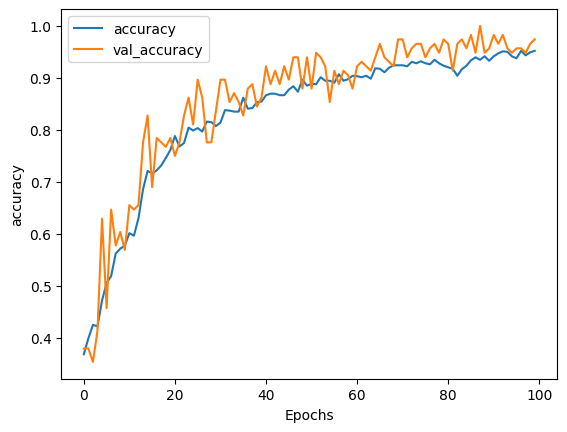

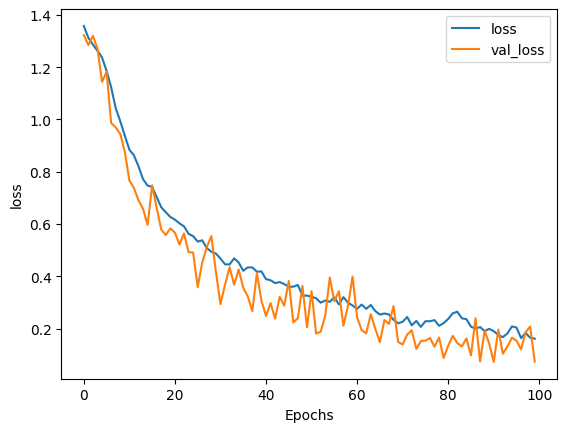

In [46]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Test

In [57]:
task = "Finish the progress report"
print(f"Input: {task}")

task_vec = tokenizer(task)
print(f"Vectorized input: {tokenizer.detokenize(task_vec)}")
print(f"\t{[x for x in task_vec.numpy()]}\n")
task_vec = np.reshape(task_vec, (1, 32))

prediction = model.predict(task_vec)[0]
print(f"Prediction vector: {prediction}")

label_vocab = label_lookup.get_vocabulary()
for label, probability in zip(label_vocab, prediction):
    percentage = probability * 100
    print(f"\t{label}: {percentage:.2f}%")

best = label_vocab[np.argmax(prediction)]
print(f"Prediction: {best}")

Input: Finish the progress report
Vectorized input: Finish the progress report [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
	[12, 220, 279, 58, 96, 187, 47, 97, 281, 278, 135, 112, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction vector: [1.3522267e-02 5.6997982e-05 9.8547953e-01 9.4108901e-04]
	not-urgent important: 1.35%
	not-urgent not-important: 0.01%
	urgent important: 98.55%
	urgent not-important: 0.09%
Prediction: urgent important


# Save

In [48]:
now = datetime.now().strftime(r"%Y-%m-%d_%H-%M-%S")
model.save(f"../model/{now}.keras")